# Determine Costas Array Frequencies, Order 8, For Yaesu Radios
## By Terry Bondy, VA3TYB

In [1]:
%plot --format svg

In [2]:
source("../common/preamble.m")

Last updated: Saturday 29 February 2020

In [3]:
source("../common/radio.m")

radioFreqAudioBwLow =  200
radioFreqAudioBwHigh =  2600
radioFreqAudioBw =  2400
radioFreqAudioMidBand =  721.11


Want to spread the frequencies equidistant across the audio bandpass for the radio, but have it centered one the geometric center of the audio bandpass for the radio. That means:

 1. $N = 8$,
 1. $costas8Freq_{8} = costas8Freq_{1} + costas8FreqDelta * (N - 1)$
 1. $\frac{costas8Freq_{1}}{radioFreqAudioBwLow} = \frac{radioFreqAudioBwHigh}{costas8Freq_{8}}$
 1. $costas8Freq_{8} < radioFreqAudioBwHigh$
 1. $radioFreqAudioBwLow < costas8Freq_{1}$
 
Using 1, 2, 4, and 5 an upper limit can be set on $costas8FreqDelta$.
$costas8FreqDelta < \frac{radioFreqAudioBwHigh - radioFreqAudioBwLow}{7}$
or 

In [4]:
(radioFreqAudioBwHigh - radioFreqAudioBwLow)/7

ans =  342.86


So let set

In [5]:
global costas8FreqDelta = 300

Substituting into 3. and re-arranging

 * $costas8Freq_{1} \cdot costas8Freq_{8} = radioFreqAudioBwLow \cdot radioFreqAudioBwHigh$
 * $costas8Freq_{1} \cdot (costas8Freq_{1} + 300 \cdot 7) = 200 \cdot 2600$
 * $costas8Freq_{1}^{2} + costas8Freq_{1} \cdot 2100 = 520000$
 
Solving for the positive root provides

In [6]:
roots([1, 2100, -520000])

ans =

  -2323.77
    223.77



Checking

In [7]:
(2323.77-223.77)/7

ans =  300


In [8]:
223.77/radioFreqAudioBwLow

ans =  1.1189


In [9]:
radioFreqAudioBwHigh/2323.77

ans =  1.1189


Setting to a reasonable nearby integer

In [10]:
global costas8FreqsCv = [225:costas8FreqDelta:2325](:)
# global costas8FreqsCv = [300:costas8FreqDelta:2400](:)


Need a frequency ordering. From _Modified Costas Signal, Levanon & Mozeson_ here is one:

In [11]:
global costas8FreqIdxCv = [ 1 8 3 6 2 7 5 4 ](:);

In [12]:
function sigValuesCv = costasBlock (...
   sampleRate, ...
   numPulses = 1, ...
   freqOffset = 0, ...
   FreqIdx, ...
   Freqs ...
)
    sigValuesCv = [ 0 ];

    if (size(FreqIdx) != size(Freqs))
      error("Expecting size(FreqIdx) == size(Freqs)")
    endif
    # Make a CV
    Freqs = Freqs(:);
    FreqIdx = FreqIdx(:);

    nFreqs = rows(Freqs);
    deltaFreq = Freqs(2) - Freqs(1);

    # Rejig the frequency array and offset so have continuous phase/value for this algorithm
    # regardless of the freqs values.
    deltaOffset = Freqs(1) - deltaFreq;
    Freqs = Freqs .- deltaOffset;
    freqOffset += deltaOffset;

    TimeCv = [0:1/sampleRate:numPulses/deltaFreq](:);
    nTimeCv = rows(TimeCv)-1;
    TimeLongCv = [0:1/sampleRate:numPulses*nFreqs/deltaFreq](:);
    OffsetPhaseCv = TimeLongCv * freqOffset;
    for idx = 1:1:nFreqs
        timeLongOffset = (idx-1)*nTimeCv+1;
        PhaseCv = TimeCv*Freqs(FreqIdx(idx)) .+ OffsetPhaseCv(timeLongOffset:timeLongOffset+nTimeCv);
        SigLoopCV = i * exp(-i*2*pi*PhaseCv);
        sigValuesCv = vertcat(sigValuesCv, SigLoopCV(2:end));
    endfor
endfunction

In [13]:
function sigValuesCv = costas8Block (...
   sampleRate, ...
   numPulses = 1, ...
   freqOffset = 0 ...
)
  global costas8FreqsCv;
  global costas8FreqIdxCv;
  sigValuesCv = costasBlock(sampleRate, numPulses, freqOffset, costas8FreqIdxCv, costas8FreqsCv);
endfunction

In [14]:
BWchannel = 100000
pulseSamples = pow2(ceil(log2(BWchannel * 2/costas8FreqDelta)))
sampleRate = pulseSamples * costas8FreqDelta

BWchannel =  100000
pulseSamples =  1024
sampleRate =  307200


In [15]:
who

Variables in the current scope:

BWchannel              costas8FreqsCv         radioFreqAudioBwLow
ans                    pulseSamples           radioFreqAudioMidBand
costas8FreqDelta       radioFreqAudioBw       sampleRate
costas8FreqIdxCv       radioFreqAudioBwHigh



In [16]:
values = costas8Block(sampleRate, 3);
size(values)
rows(values)/1024

ans =

   24577       1

ans =  24.001


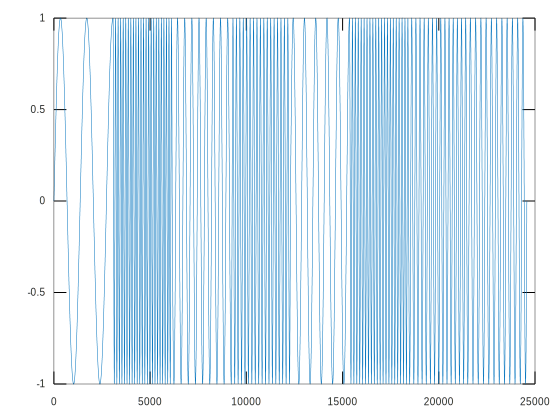

In [17]:
plot(1:1:rows(values),values)
% grid on
% grid minor
% axis([-1 2], "tic")

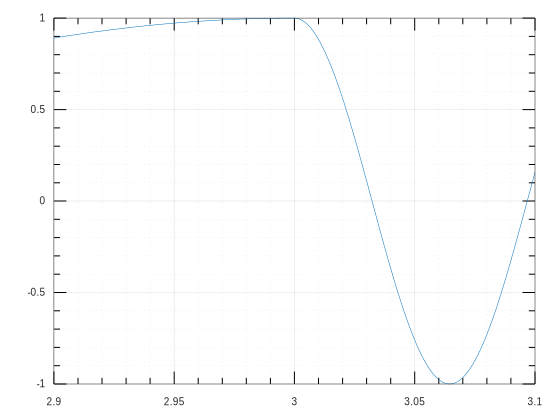

In [18]:
plot(0:300/sampleRate:300*(rows(values)-1)/sampleRate,values)
grid on
grid minor
axis([3-0.1 3+0.1], "tic")

In [19]:
function c = normxcorr2 (a, b)
  if (nargin != 2)
    print_usage ();
  endif

  ## If this happens, it is probably a mistake
  if (ndims (a) > ndims (b) || any (postpad (size (a), ndims (b)) > size (b)))
    warning ("normxcorr2: TEMPLATE larger than IMG. Arguments may be swapped.");
  endif

  a = double (a) - mean (a(:));
%  b = double (b) - mean (b(:));
  b = double (b);

  a1 = ones (size (a));
  ar = reshape (a(end:-1:1), size (a));

  c = convn (b, conj (ar), "valid");
  b = convn (b.^2, a1, "valid") .- convn (b, a1, "valid").^2 ./ (prod (size (a)));

  ## remove small machine precision errors after substraction
  b(b < 0) = 0;

  a = sumsq (a(:));
  c = reshape (c ./ sqrt (b * a), size (c));

  c(isinf (c) | isnan (c)) = 0;
endfunction


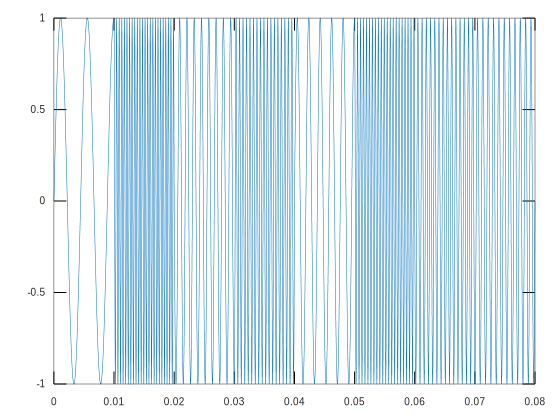

In [20]:
TimeCv = [0:1/sampleRate:(rows(values)-1)/sampleRate](:);
plot(TimeCv, values)

ans =  2048


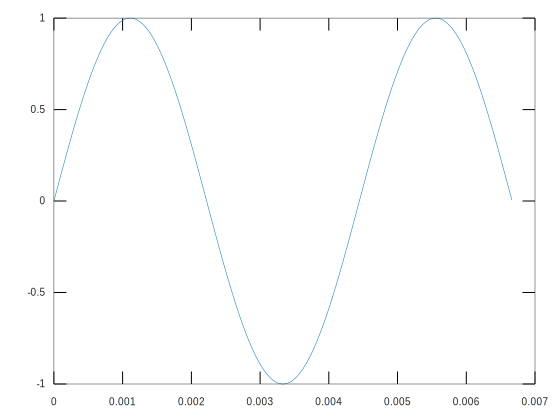

In [21]:
TimeSubpulseCv = [0:1/sampleRate:(2*pulseSamples-1)/sampleRate](:);
rows(TimeSubpulseCv)
plot(TimeSubpulseCv, values(1:2*pulseSamples))

In [22]:
# Need raised cosine for sampling subpulse
addpath("../fft")
RaisedCosineCv = rcos(pulseSamples*2);
size(RaisedCosineCv)

ans =

   2048      1



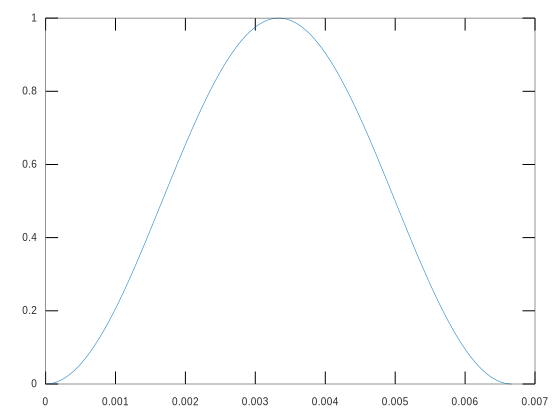

In [23]:
plot(TimeSubpulseCv, RaisedCosineCv)

In [24]:
function Resp = freqResp (values, RaisedCosineCv, pulseSamples)
    # Each column represents freq response at a given moment in time
    Resp = [];
    fracSubPulse = 1; # Must be a power of 2
    indexIncr = pulseSamples/fracSubPulse;
    freqOvr = 2; # Must be a power of 2
    for idx = 1:indexIncr:rows(values)-(rows(RaisedCosineCv)-1)
        SigLoopCV = [values(idx:idx+rows(RaisedCosineCv)-1) .* RaisedCosineCv](1:end-1);
        FftLoopCV = fftshift(fft(SigLoopCV, rows(SigLoopCV)*freqOvr+1));
        Resp = horzcat(Resp, FftLoopCV);
    endfor
endfunction

In [25]:
% Resp = rot90(freqResp(values, RaisedCosineCv, pulseSamples), 1);
% size(Resp)
size(values)
Resp = freqResp([zeros(size(RaisedCosineCv)); values; zeros(size(RaisedCosineCv))], RaisedCosineCv, pulseSamples);
Resp = Resp .* conj(Resp);
Resp = rot90(Resp, -1);
size(Resp)

ans =

   24577       1

ans =

     27   4095



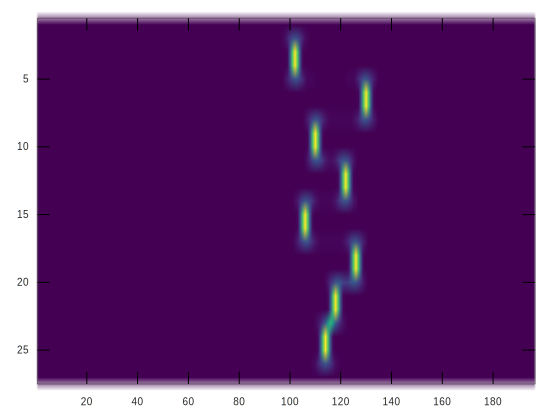

In [26]:
% imshow(Resp(end*3/7:end*4/7,1:end))
% imagesc(linspace(-sampleRate/2, sampleRate/2, columns(Resp)), 0:1:rows(Resp), Resp)
imagesc(Resp(1:end,end*10/21:end*11/21))
% axis([-1000 1000])

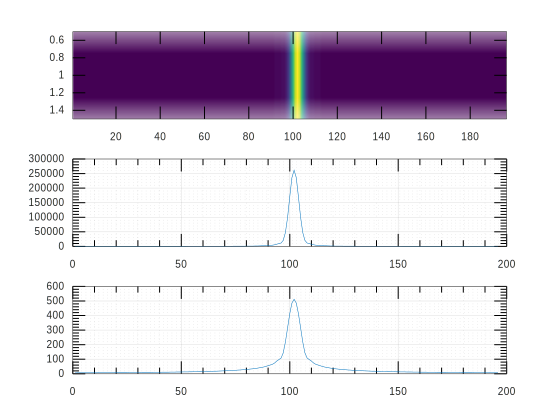

In [27]:
idx=2;
PlotResp = Resp(idx:idx,end*10/21:end*11/21);
subplot (3, 1, 1)
imagesc(PlotResp)
subplot (3, 1, 2)
plot(PlotResp)
grid on
grid minor
axis("tic")
subplot (3, 1, 3)
plot(sqrt(PlotResp))
grid on
grid minor
axis("tic")

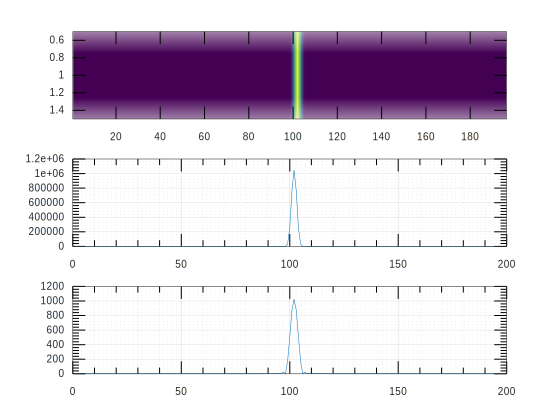

In [28]:
idx=3;
PlotResp = Resp(idx:idx,end*10/21:end*11/21);
subplot (3, 1, 1)
imagesc(PlotResp)
subplot (3, 1, 2)
plot(PlotResp)
grid on
grid minor
axis("tic")
subplot (3, 1, 3)
plot(sqrt(PlotResp))
grid on
grid minor
axis("tic")

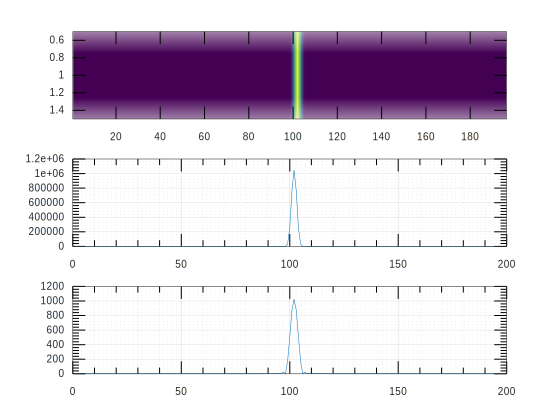

In [29]:
idx=4;
PlotResp = Resp(idx:idx,end*10/21:end*11/21);
subplot (3, 1, 1)
imagesc(PlotResp)
subplot (3, 1, 2)
plot(PlotResp)
grid on
grid minor
axis("tic")
subplot (3, 1, 3)
plot(sqrt(PlotResp))
grid on
grid minor
axis("tic")

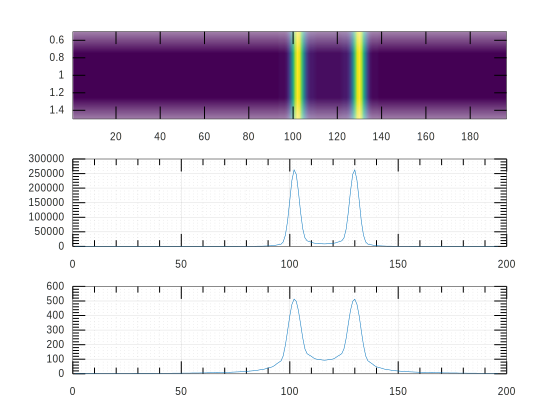

In [30]:
idx=5;
PlotResp = Resp(idx:idx,end*10/21:end*11/21);
subplot (3, 1, 1)
imagesc(PlotResp)
subplot (3, 1, 2)
plot(PlotResp)
grid on
grid minor
axis("tic")
subplot (3, 1, 3)
plot(sqrt(PlotResp))
grid on
grid minor
axis("tic")

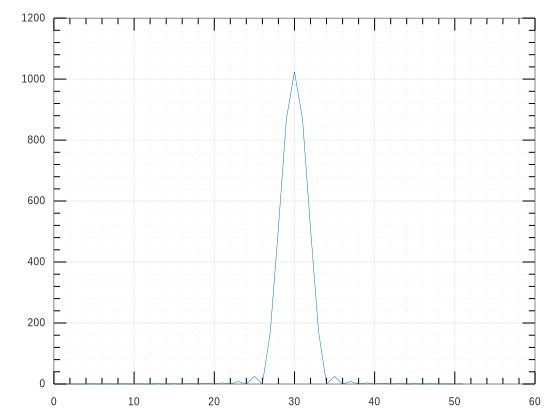

In [31]:
idx=3;
PlotResp = sqrt(Resp(idx:idx,end*40/81:end*41/81));
plot(PlotResp)
grid on
grid minor
axis("tic")

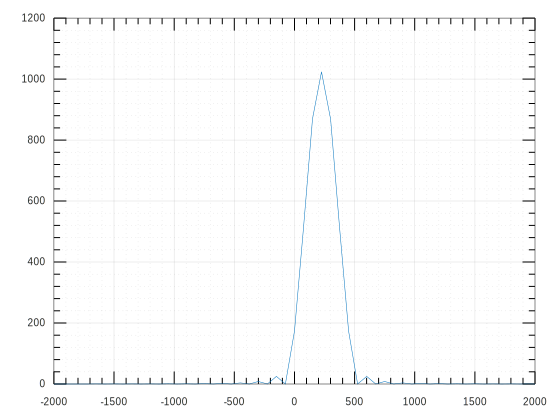

In [32]:
PlotResp = sqrt(Resp(idx,1:end));
plot(linspace(-sampleRate/2, sampleRate/2, columns(PlotResp)), PlotResp)
grid on
grid minor
axis([-2000, 2000], "tic")

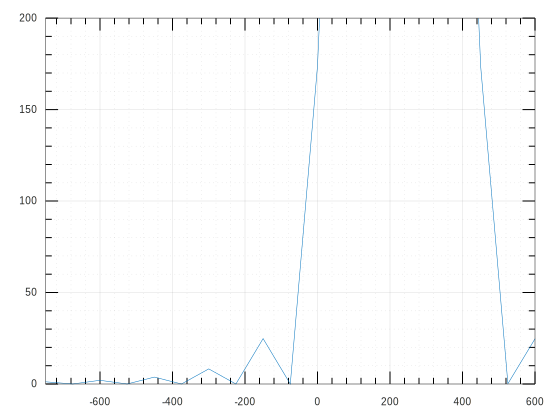

In [39]:
plot(linspace(-sampleRate/2, sampleRate/2, columns(PlotResp)), PlotResp)
grid on
grid minor
axis([-750, 600, 0, 200], "tic")

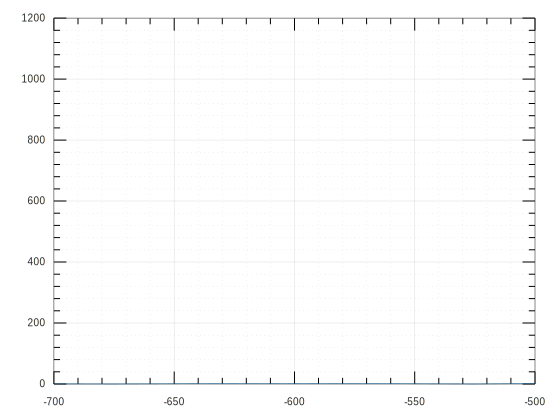

In [34]:
plot(linspace(-sampleRate/2, sampleRate/2, columns(PlotResp)), PlotResp)
grid on
grid minor
axis([-700, -500], "tic")

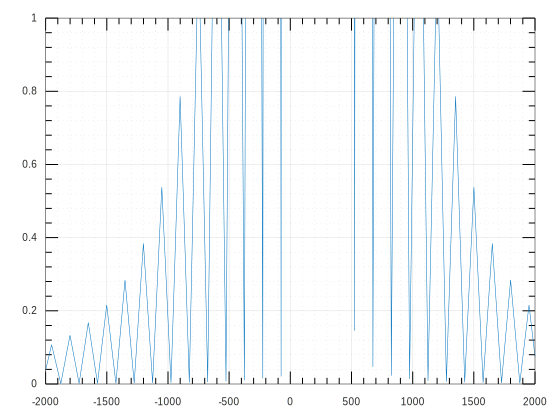

In [35]:
plot(linspace(-sampleRate/2, sampleRate/2, columns(PlotResp)), PlotResp)
grid on
grid minor
axis([-2000, 2000, 0, 1], "tic")

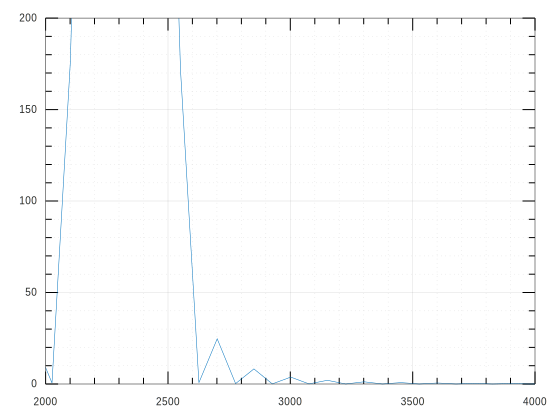

In [48]:
idx=6;
PlotResp = sqrt(Resp(idx,1:end));
plot(linspace(-sampleRate/2, sampleRate/2, columns(PlotResp)), PlotResp)
grid on
grid minor
axis([2000, 4000, 0, 200], "tic")

In [47]:
costas8FreqsCv


costas8FreqsCv =

    225
    525
    825
   1125
   1425
   1725
   2025
   2325



In [49]:
3150-2325

ans =  825


In [50]:
225 - -600

ans =  825


In [51]:
2700-2325

ans =  375


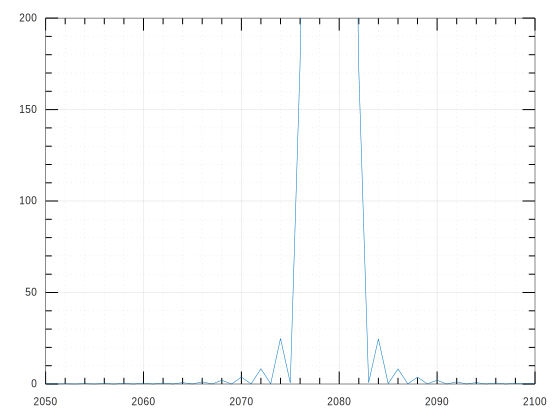

In [54]:
plot(PlotResp)
grid on
grid minor
axis([2050, 2100, 0, 200], "tic")

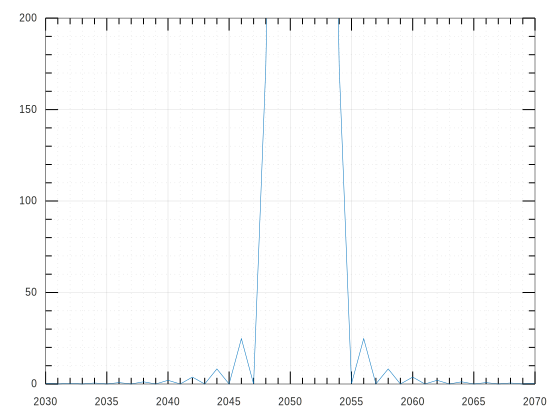

In [57]:
idx=3;
PlotResp = sqrt(Resp(idx,1:end));
plot(PlotResp)
grid on
grid minor
axis([2030, 2070, 0, 200], "tic")

In [72]:
% TemplateResp = sqrt(Resp(3:24,2040:2090));
% TemplateResp = sqrt(Resp(3:3:24,2040:2090));
TemplateResp = sqrt(Resp([1,3:3:24,1],2040:2090));
% TemplateResp = sqrt(Resp([1,3:1:24,1],2040:2090));

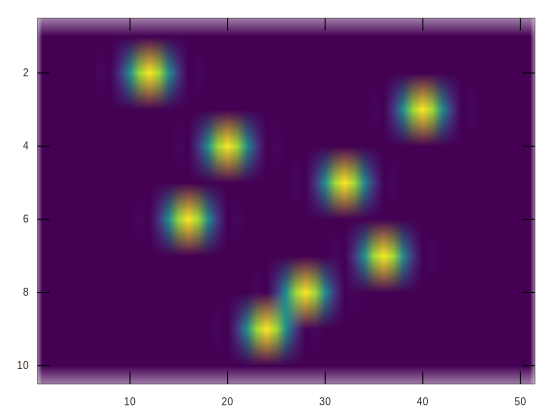

In [74]:
imagesc(sqrt(Resp([1,3:3:24,1],2040:2090)))

In [78]:
TemplateResp = Resp(3:24,2040:2090);
TemplateOnes = zeros(size(TemplateResp));
TemplateOnes(1:3:end,1:end) = 1;

In [ ]:
% WIP

function c = normxcorr2plus (template, template1s, img)
  if (nargin != 3)
    print_usage ();
  endif

  ## If this happens, it is probably a mistake
  if (ndims (template) > ndims (img) || any (postpad (size (template), ndims (img)) > size (img)))
    warning ("normxcorr2plus: TEMPLATE larger than IMG. Arguments may be swapped.");
  endif

  template = double (template) - mean (template(:));
  img = double (img);

  template1s = reshape (template1s(end:-1:1), size (template1s));
  templateRev = reshape (template(end:-1:1), size (template));

  c = convn (img, conj (templateRev), "valid");
  img = convn (img.^2, template1s, "valid") .- convn (img, template1s, "valid").^2 ./ (sum (template1s));

  ## remove small machine precision errors after substraction
  img(img < 0) = 0;

  template = sumsq (templateRev(:) .* template1s(:));
  c = reshape (c ./ sqrt (img * template), size (c));

  c(isinf (c) | isnan (c)) = 0;
endfunction
